<a href="https://colab.research.google.com/github/asudomoeva/Cancer-detection/blob/master/ADL_Final_Project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Deliverables 
● Video: a 10 minute YouTube video explaining your project / the key pieces of code / experiments you ran / and results. Should contain slides + code walkthrough.
● Complete code: either a Jupyter notebook that runs end-to-end on Colab, or a zip including source, a README, and a shell script to run it. Please include a saved model as well.

# Code

● Train a model using a subset of the training data from CAMELYON16.

● Include a script to run it on a testing image and generate a heatmap (note:
you do not need to create a 100,000 x 100,000 heatmap -- use a much lower
resolution).

# Results
● Design a thoughtful evaluation method, and include the results on at least
three images from the testing set.

● Include a saved, trained version of your model with your submission.

# Tips

●  “We surprisingly found that slimmed-down Inception architectures with only 3% of the parameters achieved similar performance to the full version”

● Authors found that using a pretrained model on ImageNet ultimately hurt accuracy (Why? Pathology images do not match the natural images from ImageNet) -- but -- it improved convergence speed. This is a good place to start. Try transfer learning
and/or fine-tuning.

● Start with a low zoom level (much smaller images), a simple model, and a small amount of data.

● Implement an end-to-end prototype (training data in -> heatmap on a test image out), then slowly scale up.

● Begin with transfer learning from a model trained on ImageNet, then fine-tuning, then consider training a model from scratch. Only after this is working end-to-end, consider data augmentation, using higher zooms,
etc.

## Setup

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (167 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130811 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.applications import VGG16, InceptionV3, VGG19, ResNet50
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

### gdrive import

In [3]:
from google.colab import drive
drive.mount('/mnt/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /mnt/gdrive


In [6]:
import os
import pandas as pd
import random

#MY_DRIVE_DIR = '/content/gdrive/My Drive'
MY_DRIVE_DIR = '/mnt/gdrive/My Drive'
#SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'Deep Learning class/slide#') # changing the path for readibility used to be #slide_data
#SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'slide_sample')
SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'slides')

print(MY_DRIVE_DIR)
print(os.path.exists(MY_DRIVE_DIR))
print(SLIDES_DIR)
print(os.path.exists(SLIDES_DIR))

/mnt/gdrive/My Drive
True
/mnt/gdrive/My Drive/slides
True


### Start by creating reference list for all of our data.

In [0]:
#images_references = !ls '/mnt/gdrive/My Drive/Deep Learning class/slides'
#images_references = !ls '/mnt/gdrive/My Drive/slide_sample'
images_references = !ls '/mnt/gdrive/My Drive/slides'

There is a tumor '099' that only has an 'xml' file. Therefore, we would be dropping that from the list. tumor '038' also has some data issues (missing mask)

In [10]:
# saving image paths into a list
image_names = []
for images in images_references:
    img = re.findall(r'tumor_\d\d\d', images)
    for i in img:
      if i != 'tumor_099' and i != 'tumor_038': # ignoring tumor99 and tumor 38
        image_names.append(i)
image_names = list(set(image_names))
image_names

['tumor_016',
 'tumor_078',
 'tumor_094',
 'tumor_019',
 'tumor_101',
 'tumor_064',
 'tumor_001',
 'tumor_075',
 'tumor_096',
 'tumor_091',
 'tumor_031',
 'tumor_035',
 'tumor_002',
 'tumor_084',
 'tumor_023',
 'tumor_110',
 'tumor_081',
 'tumor_057',
 'tumor_012',
 'tumor_059',
 'tumor_005']

## Data Exploration & Visualization
* Note that the sample code has been augmented to automate visualization
* Note dataframe with downsampling factors and basic calculations on max # of windows available at each zoom level
* Note POC of overlay and tissue identification

#### functions

In [0]:
# Download an example slide and tumor mask

# Important note: the remainder are in a Google Drive folder, linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

def choose_image(image_number):
  
  global slide_path
  global tumor_mask_path
  global slide
  global tumor_mask
  
  slide_path = os.path.join(SLIDES_DIR, 'tumor_'+image_number+'.tif')
  tumor_mask_path =  os.path.join(SLIDES_DIR, 'tumor_'+image_number+'_mask.tif')
  
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))

  for i in range(len(slide.level_dimensions)-1):
      x = slide.level_dimensions[i][0]
      y = slide.level_dimensions[i][1]
      
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      assert tumor_mask.level_dimensions[i][0] == x
      assert tumor_mask.level_dimensions[i][1] == y

      downsample = 2**i
      dim = 299.
      
      dat.append({'image': image_number, 'level': i, 'downsample factor': downsample, 'x': x, 'y': y, \
                    'max windows': int(round((x*y)/dim**2,0)-1)})
      #Dict[temp] = (float(slide.level_dimensions[i][0]), float(slide.level_dimensions[i][1]))

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  
  return slide_path, tumor_mask_path

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def zoom(i): 
  
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=i, 
                         width=slide.level_dimensions[i][0], 
                         height=slide.level_dimensions[i][1])
     

  # Example: read the entire mask at the same zoom level
  mask_image = read_slide(tumor_mask, 
                       x=0, 
                       y=0, 
                       level=i, 
                       width=tumor_mask.level_dimensions[i][0], 
                       height=tumor_mask.level_dimensions[i][1])

  # Note: the program provided by the dataset authors generates a mask with R,G,B channels.
  # The mask info we need is in the first channel only.
  # If you skip this step, the mask will be displayed as all black.
  mask_image = mask_image[:,:,0]

  return slide_image, mask_image

In [0]:
def show_slide():
  
  plt.figure('slide', figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  
  return 'slide image'

In [0]:
def show_mask():

  plt.figure('mask', figsize=(10,10), dpi=100)
  plt.imshow(mask_image, cmap='binary')
  
  return 'mask'

In [0]:
def show_overlay(a):
  
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap = 'OrRd', alpha = a)
  
  return 'overlay'

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [0]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

#### Workflow with image 031

In [0]:
downsample = 5
dat = []

choose_image('084')

Read WSI from /mnt/gdrive/My Drive/slide_sample/tumor_084.tif with width: 65536, height: 86016
Read tumor mask from /mnt/gdrive/My Drive/slide_sample/tumor_084_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (65536, 86016) downsample factor 1
Level 1, dimensions: (32768, 43008) downsample factor 2
Level 2, dimensions: (16384, 21504) downsample factor 4
Level 3, dimensions: (8192, 10752) downsample factor 8
Level 4, dimensions: (4096, 5376) downsample factor 16
Level 5, dimensions: (2048, 2688) downsample factor 32
Level 6, dimensions: (1024, 1344) downsample factor 64
Level 7, dimensions: (512, 672) downsample factor 128


('/mnt/gdrive/My Drive/slide_sample/tumor_084.tif',
 '/mnt/gdrive/My Drive/slide_sample/tumor_084_mask.tif')

Example: read the entire slide at level 5

Higher zoom levels may not fit into memory. You can use the below function to extract regions from higher zoom levels without having to read the entire image into ram.

Use the sliding window approach discussed in class to collect training data for your classifier. E.g., slide a window across the slide (for starters, use a zoomed in view, so you're not working with giant images). Save each window to disk as an image. To find the label for that image, check to the tissue mask to see if the same region contains cancerous cells.

Important: this is tricky to get right. Carefully debug your pipeline beforetraining your model. Start with just a single image, and a relatively low zoom level.

In [0]:
slide_image, mask_image = zoom(5)

In [0]:
# checking dimentions
slide_image.shape

(2688, 2048, 3)

In [0]:
# checking dimentions
mask_image.shape

(2688, 2048)

'slide image'

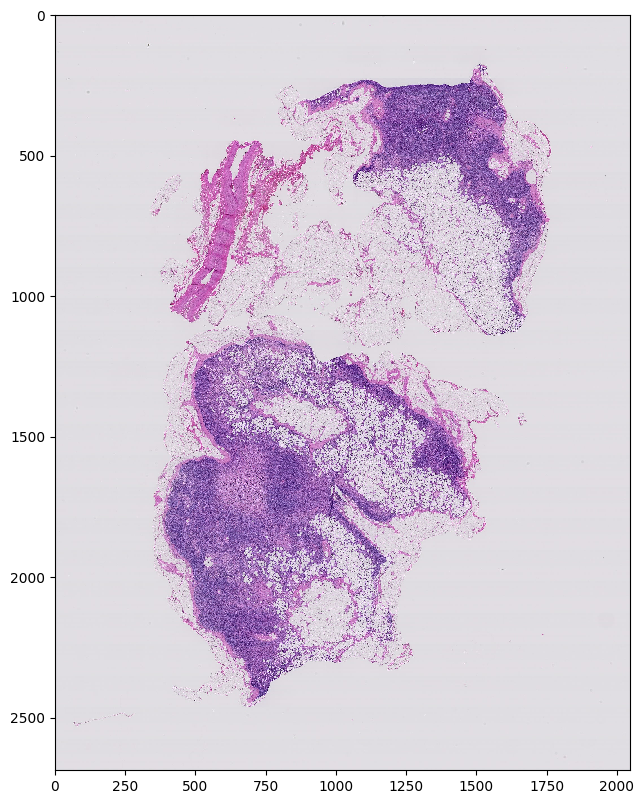

In [0]:
show_slide()

'mask'

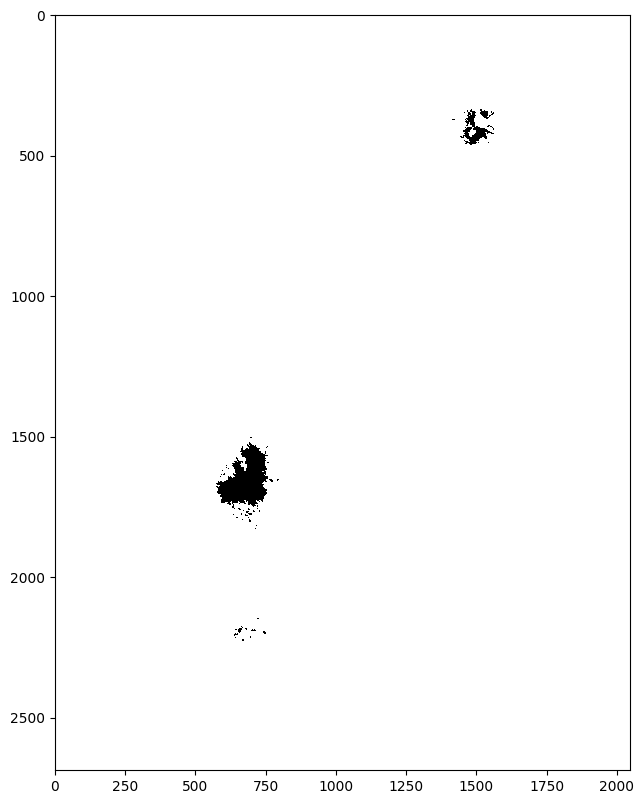

In [0]:
show_mask()

'overlay'

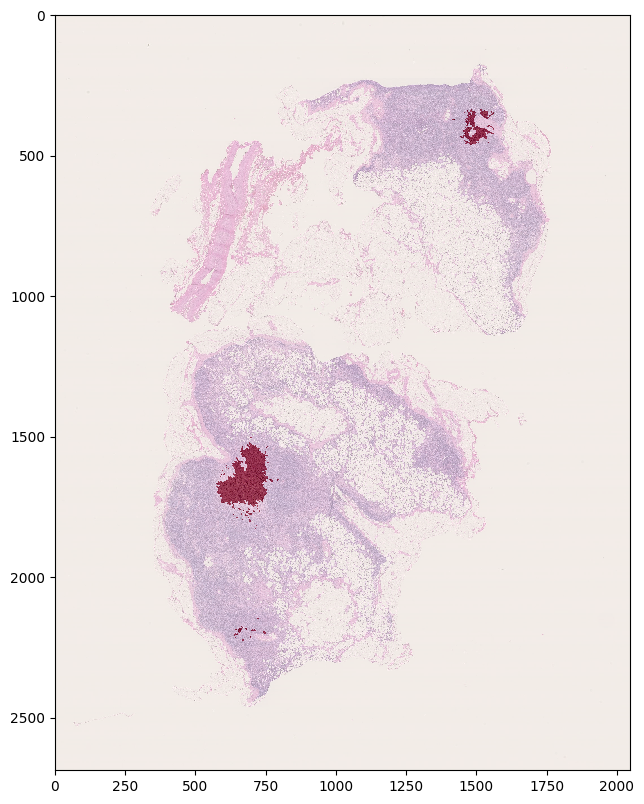

In [0]:
show_overlay(0.6)

In [0]:
df=pd.DataFrame(dat)
df

,downsample factor,image,level,max windows,x,y
0,1,084,0,63054,65536,86016
1,2,084,1,15763,32768,43008
2,4,084,2,3940,16384,21504
3,8,084,3,984,8192,10752
4,16,084,4,245,4096,5376
5,32,084,5,61,2048,2688
6,64,084,6,14,1024,1344
7,128,084,7,3,512,672


In [0]:
df['x'][5]

2048

In [0]:
#Note "actual dim" represents the dimensions on the slide image
#actual_dim = float(df['x'][4])
#downsample = float(df['x'][5])
#correction = (downsample/actual_dim) * int(df['downsample factor'][5])
#correction

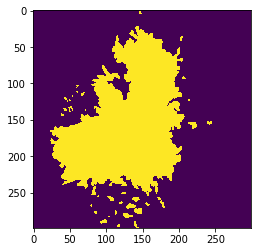

In [0]:
# Example: extract a (cancer) region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.

region = read_slide(tumor_mask, x=(550*32), y=(1500*32), level=5, width=299, height=299)[:,:,0]
plt.imshow(region)

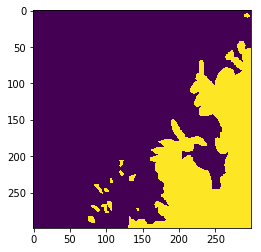

In [0]:
# Example: extract a (cancer) region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.

region = read_slide(tumor_mask, x=(550*32), y=(1500*32), level=4, width=299, height=299)[:,:,0]
plt.imshow(region)

In [0]:
# THIS IS THE PROPER ADJUSTMENT TO SHOW THAT 32 FILTER IS THE CORRECT ONE TO USE WITH MAX AND MIN ACCORDINGLY

#region = read_slide(tumor_mask, x=(1400*32), y=(4500*32), level=5, width=299, height=299)[:,:,0]
#plt.imshow(region)

In [0]:

tissue_pixels = list(find_tissue_pixels(slide_image))
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

1232170 tissue_pixels pixels (17.1 percent of the image)


In [0]:
mask_image.shape

(2688, 2048)

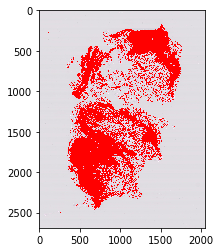

In [0]:
tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [0]:
tissue_regions.shape

(2688, 2048, 3)

## Modeling - Data Prep

### Defining Helper Functions

In [0]:
def is_tissue_in_window(window, intensity=0.8):
    im_gray = rgb2gray(window)
    x_indices = np.where(im_gray <= intensity)[0]
    return len(x_indices) > 0

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def create_dataset(level, image_names):
    #creating lists for final data and labels
    data = []
    labels = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level
        x_max = slide.level_dimensions[level][0]
        y_max = slide.level_dimensions[level][1] 
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #sanity check  
        assert tumor_mask.level_dimensions[level][0] == x_max
        assert tumor_mask.level_dimensions[level][1] == y_max

        # choosing downsample factor
        downsample_factor = int(slide.level_downsamples[level])

        #initiatize coordinates
        x0 = 0 #int(.05*x_max) possibility to create padding
        y0 = 0 #int(.05*y_max) possibility to create padding

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))

        #calculate how many steps we can take with 299x299 window
        x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        print('x steps: '+ str(x_steps) + 'y steps: '+ str(y_steps))
        
        for i in range(x_steps):
            for j in range(y_steps): 
                #generating a window from the original slide
                window = read_slide(slide, 
                                 x=int(x0)*downsample_factor, 
                                 y=int(y0)*downsample_factor, 
                                 level=level, 
                                 width=int(x_dim), 
                                 height=int(y_dim))
                #conducting sanity check
                assert window.shape == (x_dim, y_dim, 3)

                #if window contains tissue, append to train
                if is_tissue_in_window(window) is True:
                    #continue # No tissue in this window, don't add to train or test
                    data.append(window)
                    # read the tumor mask view that corresponds to the window
                    window_mask = read_slide(tumor_mask, 
                                     x=int(x0)*downsample_factor, 
                                     y=int(y0)*downsample_factor, 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))[:,:,0]

                    #if window contains cancer, append 1 to labels; else 0
                    if np.count_nonzero(window_mask.flatten()) > 0:
                        labels.append(1)
                    else:
                        labels.append(0)

                #move the sliding window on y axis
                y0 = y0 + y_dim

            #move the sliding window on x axis
            x0 = x0 + x_dim
            # reset y0 to start
            y0 = 0 #int(.05*y_max) if using padding

    return data, labels


In [0]:
#SLIDES_DIR

'/mnt/gdrive/My Drive/slide_sample'

In [0]:
#slide_path = os.path.join('/content/gdrive/My Drive/Deep Learning class/slides/tumor_023.tif')
#slide = open_slide(slide_path)

### Modeling - sample data

Creating the dataset and labels at level 5. There is room for conversation to be had around how to approach the imbalanced dataset. Random oversampling might not be the best choice. We might want to consider using class_weight='balanced' (if possible to use with deep learning models).

CG - either way, doesn't matter to me

In [0]:
sample_images = random.sample(image_names, 5)

In [13]:
sample_images

['tumor_084', 'tumor_023', 'tumor_101', 'tumor_078', 'tumor_019']

### Train/test split

In [15]:
data, labels =  create_dataset(4, sample_images)
#should we rescale the dataset?
data = np.asarray(data) / 255.0
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
print(np.bincount(y_train))

/mnt/gdrive/My Drive/slides/tumor_084.tif
/mnt/gdrive/My Drive/slides/tumor_084_mask.tif
opening slide & mask..
dims: 4096 5376
x steps: 12y steps: 16
/mnt/gdrive/My Drive/slides/tumor_023.tif
/mnt/gdrive/My Drive/slides/tumor_023_mask.tif
opening slide & mask..
dims: 6112 13824
x steps: 19y steps: 45
/mnt/gdrive/My Drive/slides/tumor_101.tif
/mnt/gdrive/My Drive/slides/tumor_101_mask.tif
opening slide & mask..
dims: 8704 4480
x steps: 28y steps: 13
/mnt/gdrive/My Drive/slides/tumor_078.tif
/mnt/gdrive/My Drive/slides/tumor_078_mask.tif
opening slide & mask..
dims: 5888 6944
x steps: 18y steps: 22
/mnt/gdrive/My Drive/slides/tumor_019.tif
/mnt/gdrive/My Drive/slides/tumor_019_mask.tif
opening slide & mask..
dims: 6112 13728
x steps: 19y steps: 44
[1307  162]


In [16]:
len(X_train)

1469

In [18]:
balance_ratio = np.bincount(y_train)[0]/np.bincount(y_train)[1]
balance_ratio

8.067901234567902

In [0]:
#https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
class_weights = {0: 1, 1: balance_ratio}

In [0]:
# managing the imbalanced dataset by oversampling
#ros = RandomOverSampler()
#X_train_oversample, y_train_oversample = ros.fit_sample(
#    X_train, y_train)
#print(X_train.shape)
#print(X_train_oversample.shape)
#print(np.bincount(y_train_oversample))

### Modeling - Data augmentation

### Modeling - simple, dense network

starting with a dense model -- before trying even a CNN or a pre-trained model, for a baseline

In [20]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Flatten(input_shape=(299,299,3)))
#model.add(layers.Dense(128, activation=tf.nn.relu, input_dim = 299*299*3))
model.add(layers.Dense(128, activation=tf.nn.relu))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
          

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


In [0]:
model.compile(optimizer=optimizers.adam(lr=3e-5), 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#note: learning rate chosen from best practice heuristic suggested here: http://karpathy.github.io/2019/04/25/recipe/

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 268203)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               34330112  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 34,330,241
Trainable params: 34,330,241
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), batch_size = 20, class_weight = class_weights)
history

Instructions for updating:
Use tf.cast instead.
Train on 1469 samples, validate on 164 samples
Epoch 1/10
1469/1469 [==============================] - 9s 6ms/step - loss: 2.3790 - acc: 0.7216 - val_loss: 0.4715 - val_acc: 0.8780
Epoch 2/10
1469/1469 [==============================] - 5s 4ms/step - loss: 0.9123 - acc: 0.7543 - val_loss: 0.5121 - val_acc: 0.8902
Epoch 3/10
1469/1469 [==============================] - 5s 4ms/step - loss: 0.8282 - acc: 0.7781 - val_loss: 0.4097 - val_acc: 0.9207
Epoch 4/10
1469/1469 [==============================] - 5s 4ms/step - loss: 0.8670 - acc: 0.7468 - val_loss: 0.6287 - val_acc: 0.8720
Epoch 5/10
1469/1469 [==============================] - 5s 4ms/step - loss: 0.8569 - acc: 0.7679 - val_loss: 0.3684 - val_acc: 0.9451
Epoch 6/10
1469/1469 [==============================] - 5s 4ms/step - loss: 0.8562 - acc: 0.8291 - val_loss: 0.3294 - val_acc: 0.9512
Epoch 7/10
1469/1469 [==============================] - 5s 4ms/step - loss: 0.8010 - acc: 0.8271 - va

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('')
print('Validation accuracy:', test_acc)

164/164 [==============================] - 0s 2ms/step

Validation accuracy: 0.9390243902439024


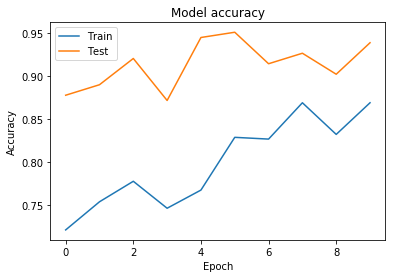

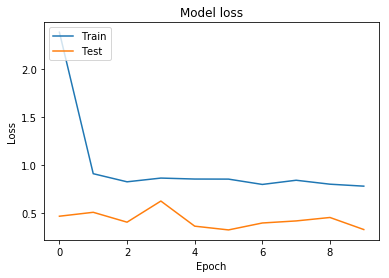

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

### Transfer Learning

In [0]:
# using inception
inception = InceptionV3(weights='imagenet',include_top=False, input_shape=(299, 299, 3))

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step


In [0]:
inception.trainable = False

In [0]:
#reshaping the data
X_train = X_train.reshape(X_train.shape[0], 299, 299, 3)

# setting up the model
EPOCHS = 5

model_inception = Sequential()
model_inception.add(inception)
model_inception.add(Flatten())
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dense(2, activation='softmax'))

model_inception.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) 
                      #,auc_roc]) #potentially might want to use roc_auc for metrics

history_inception = model_inception.fit(
      X_train, y_train,
      epochs=EPOCHS,
      validation_split=0.1,
      verbose=1,
      shuffle=True,
      batch_size=16)

IndexError: ignored

In [0]:
# inspecting ROC AUC score on hold out test dataset
X_test = X_test.reshape(X_test.shape[0], 299, 299, 3)
y_pred = model_inception.predict(X_test, batch_size=None)
final_pred = []
for point in y_pred:
  final_pred.append(np.argmax(point))
test_score = roc_auc_score(y_test, final_pred)
print(test_score)

## The following is an mvp for creating training data from a single slide, at zoom level 5

In [0]:
# x dimensions from 0 to 500 are slide artifacts
#500./x_max
#y dimensions from 0 to ~1000 are slide artifacts
#1000./y_max

#### Create training data - sliding window pseudocode

for window in image:

	if window contains tissue:
		append window to train_set

		if window contains cancer:
			label = 1
		else:
			label = 0

In [0]:
def is_tissue_in_window(window, intensity=0.8):
  im_gray = rgb2gray(window)
  x_indices = np.where(im_gray <= intensity)[0]
  return len(x_indices) > 0

In [0]:
#MVP with zoom level 5
train = []
labels = []
masks = []

#dimensions at level 5
x_max = slide.level_dimensions[5][0]
y_max = slide.level_dimensions[5][1] 

#create padding to avoid silde edges.. empirically, 15% seemed reasonable
x0 = 0 #int(.05*x_max) # changed to 5%
y0 = 0 #int(.05*y_max) # changed to 5%

#size of window
x_dim, y_dim = 299., 299.
size = (int(x_dim), int(y_dim))

#level
L = int(5)

# calculate how many steps we can take with 299x299 window
x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)

#from above, 'correction' factor for relating dimensions back to visual indications
#this correction factor is invariant for the zoom level, assuming we adjust x_max, y_max as defined above to specific level of interest
#x0 = x0*16 #I think we were wrong in our correction factor
#y0 = y0*16 #I think we were wrong in our correction factor       

for i in range(x_steps):
    for j in range(y_steps): 
        #location = (int(x0)*16, int(y0)*16) # just added
        # generating a window from the original slide
        window = read_slide(slide, 
                         x=int(x0)*32, 
                         y=int(y0)*32, 
                         level=L, 
                         width=299, 
                         height=299)
                         #as_float=True)
        #window = slide.read_region(location, L, size) 
        #window = window.convert('RGB')
        #window = np.asarray(window)
        assert window.shape == (x_dim, y_dim, 3)

        #If window contains tissue, append to train
        if is_tissue_in_window(window) is True:
            #continue # No tissue in this window, don't add to train or test
            train.append(window)
            # read the tumor mask view that corresponds to the window
            window_mask = read_slide(tumor_mask, 
                             x=int(x0)*32, 
                             y=int(y0)*32, 
                             level=L, 
                             width=299, 
                             height=299)[:,:,0]
            #window_mask = tumor_mask.read_region(location, L, size)
            #window_mask = window_mask.convert('RGB')
            #window_mask = np.asarray(window_mask)[:,:,0]
            masks.append(window_mask)

            #if window contains cancer, append 1 to labels; else 0
            if np.count_nonzero(window_mask.flatten()) > 0: # check with team if there is a better way to check pixels
                labels.append(1)
            else:
                labels.append(0)

        y0 = y0 + y_dim # changed the sliding direction to adjust for correction factor
    x0 = x0 + x_dim # changed the sliding direction to adjust for correction factor
    y0 = 0 #int(.05*y_max) # need to reset y0 to start


NameError: ignored

In [0]:
# After adding filter for windows with tissue
print("Remaining number of windows after tissue drop: {}, Total number of windows: {} ".format(len(train), x_steps*y_steps))

In [0]:
# checking the shape
train[0].shape

In [0]:
# looking into the number of cancer labels generated
sum(labels)

In [0]:
# checking labels length
assert len(labels) == len(train)

Visualizing the windows to see that the movement has been captured! Looks like it slides perfectly now!

In [0]:
# check if the windows actually move properly
plt.imshow(train[10])

In [0]:
plt.imshow(train[11])

As a sanity check, visualizing all the picked up windows with cancer to see that it makes sense!

In [0]:
pos_labels = np.argsort(labels)[-9:]
plt.imshow(masks[pos_labels[0]])

In [0]:
plt.imshow(masks[pos_labels[1]])

In [0]:
plt.imshow(masks[pos_labels[2]])

In [0]:
plt.imshow(masks[pos_labels[3]])

In [0]:
plt.imshow(masks[pos_labels[4]])

In [0]:
plt.imshow(masks[pos_labels[5]])

In [0]:
plt.imshow(masks[pos_labels[6]])

In [0]:
plt.imshow(masks[pos_labels[7]])

In [0]:
plt.imshow(masks[pos_labels[8]])